**Survival analysis**

Following `pymc` tutorial [here](https://docs.pymc.io/en/v3/pymc-examples/examples/survival_analysis/survival_analysis.html)

In [1]:
import arviz as az
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns
from scipy.special import expit, logit
from scipy.optimize import curve_fit
import statsmodels.api as sm
import daft
from causalgraphicalmodels import CausalGraphicalModel
%matplotlib inline

import theano
from pymc3.distributions.timeseries import GaussianRandomWalk
from theano import tensor as T

In [2]:
%load_ext nb_black
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.95  # sets default credible interval used by arviz

sns.set_context("talk")

def standardize(x):
    x = (x - np.mean(x)) / np.std(x)
    return x

<IPython.core.display.Javascript object>

# Inspect data

In [3]:
df = pd.read_csv(pm.get_data("mastectomy.csv"))

df.event = df.event.astype(np.int64)
df.metastasized = (df.metastasized == "yes").astype(np.int64)
n_patients = df.shape[0]
patients = np.arange(n_patients)

<IPython.core.display.Javascript object>

In [5]:
df.head()

,time,event,metastasized
0,23,1,0
1,47,1,0
2,69,1,0
3,70,0,0
4,100,0,0


<IPython.core.display.Javascript object>

In [6]:
df.shape

(44, 3)

<IPython.core.display.Javascript object>

Each row represents observations from a woman diagnosed with breast cancer that underwent a mastectomy. The column time represents the time (in months) post-surgery that the woman was observed. The column event indicates whether or not the woman died during the observation period. The column metastasized represents whether the cancer had metastasized prior to surgery.

- each patient was only observed once

This tutorial analyzes the relationship between survival time post-mastectomy and whether or not the cancer had metastasized.

An important, but subtle, point in survival analysis is censoring. Even though the quantity we are interested in estimating is the time between surgery and death, we do not observe the death of every subject. At the point in time that we perform our analysis, some of our subjects will thankfully still be alive. In the case of our mastectomy study, df.event is one if the subject’s death was observed (the observation is not censored) and is zero if the death was not observed (the observation is censored).

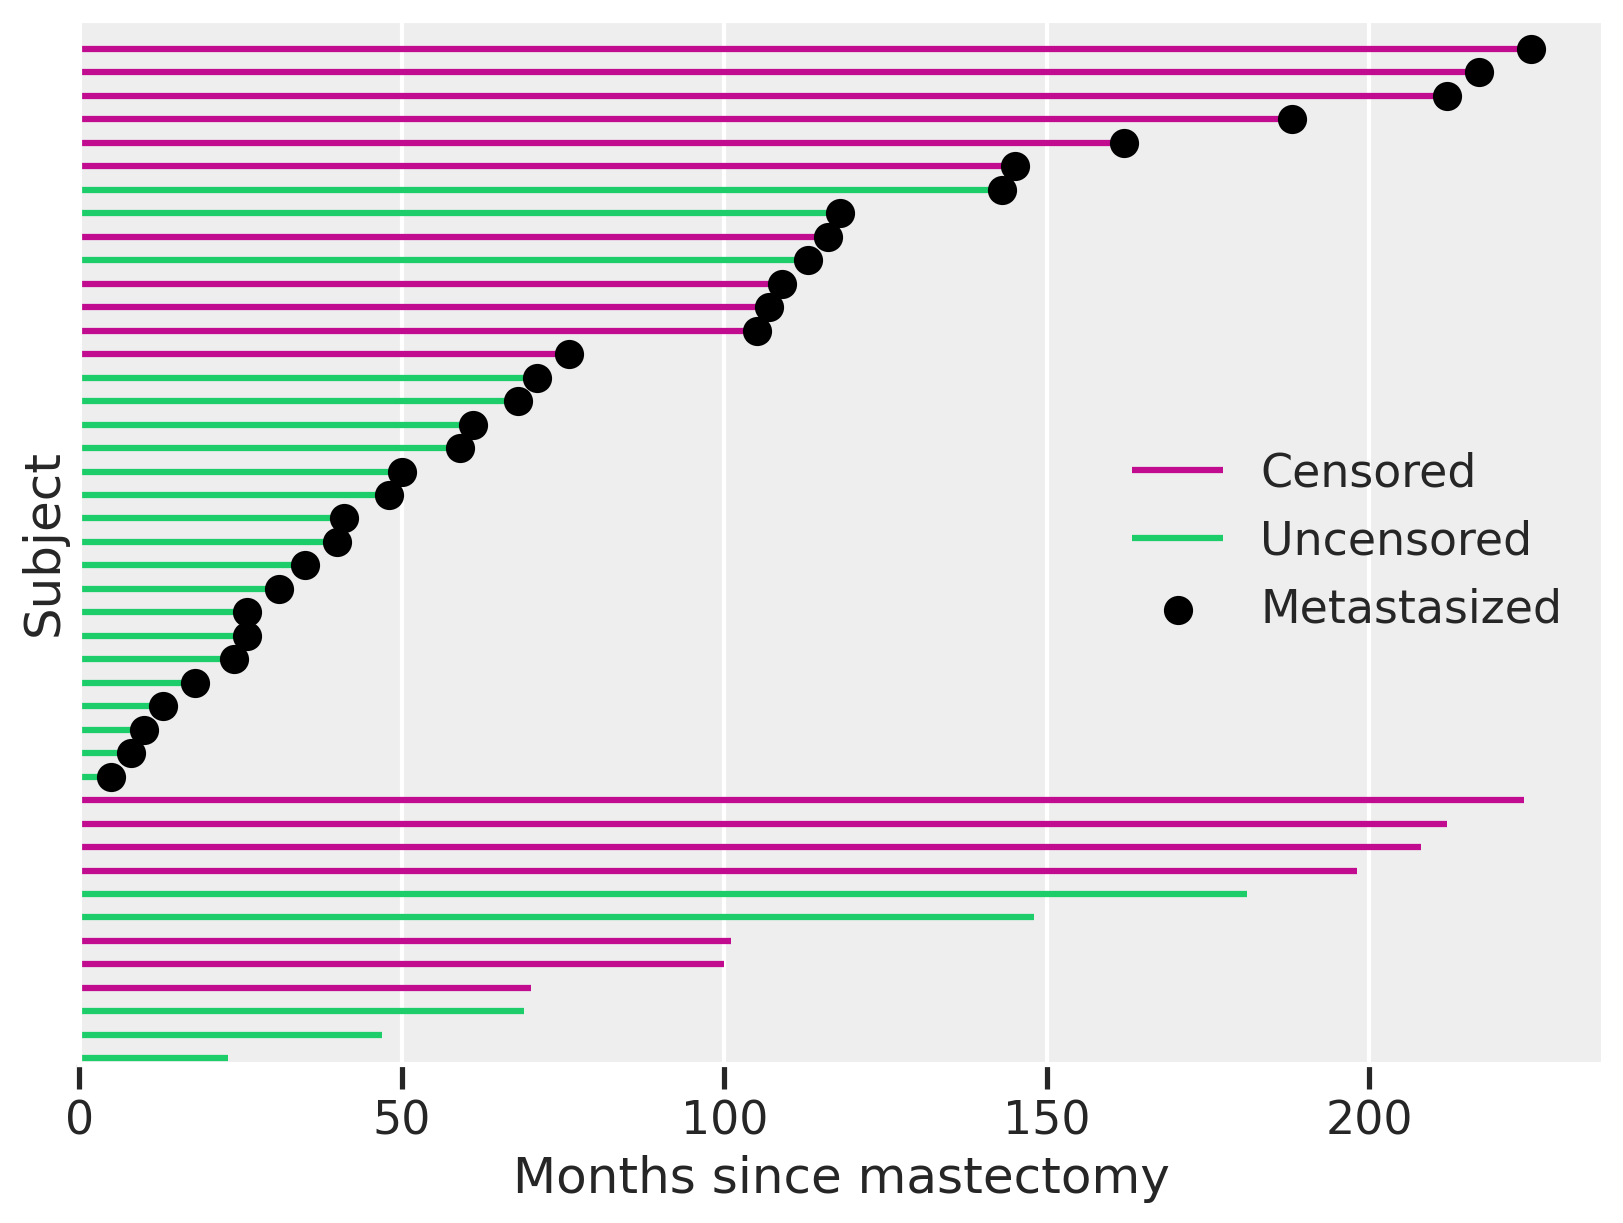

<IPython.core.display.Javascript object>

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hlines(
    patients[df.event.values == 0], 0, df[df.event.values == 0].time, color="C3", label="Censored"
)

ax.hlines(
    patients[df.event.values == 1], 0, df[df.event.values == 1].time, color="C7", label="Uncensored"
)

ax.scatter(
    df[df.metastasized.values == 1].time,
    patients[df.metastasized.values == 1],
    color="k",
    zorder=10,
    label="Metastasized",
)

ax.set_xlim(left=0)
ax.set_xlabel("Months since mastectomy")
ax.set_yticks([])
ax.set_ylabel("Subject")

ax.set_ylim(-0.25, n_patients + 0.25)

ax.legend(loc="center right");

When an observation is censored (df.event is zero), df.time is not the subject’s survival time. All we can conclude from such a censored observation is that the subject’s true survival time exceeds df.time.

This is enough basic survival analysis theory for the purposes of this tutorial; for a more extensive introduction, consult Aalen et al

In [61]:
%watermark -n -u -v -iv -w

Last updated: Fri Apr 08 2022

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

scipy      : 1.6.0
statsmodels: 0.12.2
arviz      : 0.11.1
sys        : 3.8.6 | packaged by conda-forge | (default, Jan 25 2021, 23:22:12) 
[Clang 11.0.1 ]
pandas     : 1.2.1
matplotlib : 3.3.4
seaborn    : 0.11.1
daft       : 0.1.0
pymc3      : 3.11.0
numpy      : 1.20.1

Watermark: 2.1.0



<IPython.core.display.Javascript object>